# Dogs Image Classifcation
**The purposes of this notebook are:**

Experimenting early stopping

In [1]:
import neptune

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

# torchvision: popular datasets, model architectures, and common image transformations for computer vision.
import torchvision

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchsummary import summary
import pytorch_lightning as pl

from sklearn.model_selection import train_test_split

import glob
import os.path as osp
import os
import numpy as np
from PIL import Image # to read images
import ntpath
# import pandas as pd

# import xml.etree.ElementTree as ET # for parsing XML
import matplotlib.pyplot as plt # to show images
import matplotlib.patches as patches
from tqdm import tqdm_notebook as tqdm
import time
%matplotlib inline

/home/ishay/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ishay/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ishay/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ishay/anaconda3/envs/myen

In [7]:
# callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
# model.set_callbacks(callbacks)

In [8]:
neptune.init('MM-IT-DOGS/dogs-project')

Project(MM-IT-DOGS/dogs-project)

In [2]:
PARAMS = {'random_seed' : 42,
          'batch_size' : 632,
          'learning_rate': 0.03,
          'momentum': 0.9,
          'n_epoch': 50,
          'optimizer': "sgd",
          'fc_dropout': 0.5}

In [53]:
neptune.create_experiment(name='try_out_early_stopping', 
                          params=PARAMS,
                          tags=['local', 'classification', 'checkoint', 'early_stopping'],
                          description='Try one version of early stopping'
                         )

https://ui.neptune.ai/MM-IT-DOGS/dogs-project/e/SAN-58


Experiment(SAN-58)

In [3]:
# BASE_PATH = "/home/ishay_telavivi/data"
BASE_PATH = "/home/ishay/Documents/MDLI/dogs/data" #Ishay
#BASE_PATH = "g:\\My Drive\\AI\\MDLI #3 2019\\Projects\\dogs" #Michael
#IMGS_PATH = BASE_PATH + "\\Data\\Images\\" #Michael
#ANNTN_PATH = BASE_PATH + "\\Data\\Annotation\\" #Michael

In [4]:
    CHECKPOINTS_DIR = '/home/ishay/Documents/MDLI/dogs/artifacts'

## Examine directory structure and content

In [5]:
print(os.listdir(BASE_PATH))

['Annotation', 'Images']


**Images**

In [6]:
IMGS_PATH = BASE_PATH + "/Images/" #Ishay
#breed_list = os.listdir(BASE_PATH + IMGS_PATH)[:5]

breed_list = os.listdir(IMGS_PATH)

print("Number of breeds:",len(breed_list))

Number of breeds: 120


## Create a Dataset and DataLoader Classes

The following code is based on the following links:

- https://pytorch.org/docs/stable/torchvision/datasets.html
- https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
- https://discuss.pytorch.org/t/how-to-divide-dataset-into-training-validation-and-testing/38764/5

In [7]:
IMAGE_WIDTH = 120
IMAGE_LENGTH = 120

In [8]:
# Must at least transform to tensor
# We allow different transformation per dataset. For example we might want to crop the training, but leave the
# eval and test sets uncropped
transform = {"train": T.Compose([ 
                T.Resize((IMAGE_WIDTH,IMAGE_LENGTH)),
                T.ToTensor(),
                T.Normalize((0.4766, 0.4525, 0.3917), (0.2613, 0.2559, 0.2605)),
                ]),
             "eval": T.Compose([ 
                T.Resize((IMAGE_WIDTH,IMAGE_LENGTH)),
                T.ToTensor(),
                T.Normalize((0.4766, 0.4525, 0.3917), (0.2613, 0.2559, 0.2605)),
                ]),
             "test": T.Compose([ 
                T.Resize((IMAGE_WIDTH,IMAGE_LENGTH)),
                T.ToTensor(),
                 T.Normalize((0.4766, 0.4525, 0.3917), (0.2613, 0.2559, 0.2605)),
                ])}

In [9]:
# If we want to create datasets with different transformations for train/eval/test, we must create 3 identical
# sets, and then select the specific indices from each per data
train_data_set = ImageFolder(IMGS_PATH,transform=transform["train"])
eval_data_set = ImageFolder(IMGS_PATH,transform=transform["eval"])
test_data_set = ImageFolder(IMGS_PATH,transform=transform["test"])

In [10]:
train_data_set.classes[:5]

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu']

In [11]:
n_class = len(train_data_set.classes)
n_class

120

In [12]:
train_data_set.imgs[:5]

[('/home/ishay/Documents/MDLI/dogs/data/Images/n02085620-Chihuahua/n02085620_10074.jpg',
  0),
 ('/home/ishay/Documents/MDLI/dogs/data/Images/n02085620-Chihuahua/n02085620_10131.jpg',
  0),
 ('/home/ishay/Documents/MDLI/dogs/data/Images/n02085620-Chihuahua/n02085620_10621.jpg',
  0),
 ('/home/ishay/Documents/MDLI/dogs/data/Images/n02085620-Chihuahua/n02085620_1073.jpg',
  0),
 ('/home/ishay/Documents/MDLI/dogs/data/Images/n02085620-Chihuahua/n02085620_10976.jpg',
  0)]

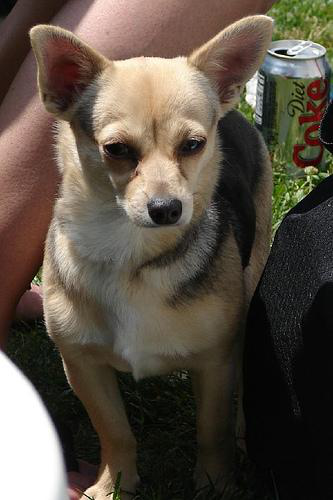

In [13]:
Image.open(train_data_set.imgs[0][0])

In [14]:
# Make sure they are identical

In [15]:
train_data_set.imgs[:5] == eval_data_set.imgs[:5]

True

In [16]:
# Targets gives the indexed labels per sample
len(set(train_data_set.targets))

120

In [17]:
list(set(train_data_set.targets))[:5]

[0, 1, 2, 3, 4]

In [18]:
# Now split the dataset

In [19]:
dataset_size = len(train_data_set) # This is not only the train as this phase, but the whole data.
dataset_size

20580

In [20]:
indices = list(range(dataset_size))

In [21]:
# Split the data like: {train: 0.7, eval: 0.2, test: 0.1}
train_split = 0.7
eval_split = 0.9 # (0.7 + 0.2)
shuffle_dataset = True

In [22]:
# Set the indices for split
split1 = int(np.floor(train_split * dataset_size))
split2 = int(np.floor(eval_split * dataset_size))
print(split1, split2)

14405 18522


In [23]:
if shuffle_dataset :
    np.random.seed(PARAMS["random_seed"])
    np.random.shuffle(indices)

In [24]:
train_indices, eval_indices, test_indices = indices[:split1], indices[split1:split2], indices[split2:]

In [25]:
print(len(train_indices), len(eval_indices), len(test_indices))

14405 4117 2058


In [26]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
eval_sampler = SubsetRandomSampler(eval_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [27]:
# Create the loaders
train_loader = DataLoader(train_data_set, batch_size=PARAMS["batch_size"], 
                                           sampler=train_sampler)
eval_loader = DataLoader(eval_data_set, batch_size=PARAMS["batch_size"],
                                                sampler=eval_sampler)
test_loader = DataLoader(test_data_set, batch_size=1,
                                                sampler=test_sampler)

## Bulid a Net

In [28]:
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cpu


In [31]:
class DogsClf(nn.Module):
    def __init__(self):
        super().__init__()
        
        # First set of conv (on input size)
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(10) # Need to specify the number of channels (depth)

        
        # Second set of covs (on input size / 2)
        self.conv4 = nn.Conv2d(10, 20, kernel_size=5, padding=2)
        self.conv4_bn = nn.BatchNorm2d(20) # Need to specify the number of channels (depth)

        # Thirs set of covs (on input size / 4)
        self.conv7 = nn.Conv2d(20, 40, kernel_size=5, padding=2)    
        self.conv7_bn = nn.BatchNorm2d(40) # Need to specify the number of channels (depth)

        
        # After maxpool I got left with on input size / 8
        
        # Linear(in_features, out_features, bias=True)
        self.fc1 = nn.Linear(15*15*40, 100)
        self.fc2 = nn.Linear(100, n_class)
        #self.fc2 = nn.Linear(15*15*40, n_class)
        
        # MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.max_pool = nn.MaxPool2d(2)
        # ReLU(inplace=False)
        self.relu = nn.ReLU()
        self.conv_dropout = nn.Dropout(p=PARAMS["fc_dropout"])
        
        
    def forward(self, x):
        # First set of conv (on input size)
        x = self.relu(self.conv1_bn(self.conv1(x)))

        # Maxpool
        x = self.max_pool(x)              
        # Second set of covs (on input sizse / 2)
        x = self.relu(self.conv4_bn(self.conv4(x)))

        # Maxpool
        x = self.max_pool(x)              
        # Third set of covs (on input sizse / 4)
        x = self.relu(self.conv7_bn(self.conv7(x)))

        # Maxpool
        x = self.max_pool(x) 
        # Need to flatten
        x = x.view(-1, (15*15*40))
        
        # FC
        x = self.relu(self.fc1(x))
        x = self.conv_dropout(x)
        x = self.fc2(x)
        
        return x # F.log_softmax(x, dim=1)


In [38]:
model = DogsClf().to(device)

In [39]:
summary(model, input_data=(3,IMAGE_WIDTH, IMAGE_LENGTH))

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 120, 120]        760
├─BatchNorm2d: 1-2                       [-1, 10, 120, 120]        20
├─ReLU: 1-3                              [-1, 10, 120, 120]        --
├─MaxPool2d: 1-4                         [-1, 10, 60, 60]          --
├─Conv2d: 1-5                            [-1, 20, 60, 60]          5,020
├─BatchNorm2d: 1-6                       [-1, 20, 60, 60]          40
├─ReLU: 1-7                              [-1, 20, 60, 60]          --
├─MaxPool2d: 1-8                         [-1, 20, 30, 30]          --
├─Conv2d: 1-9                            [-1, 40, 30, 30]          20,040
├─BatchNorm2d: 1-10                      [-1, 40, 30, 30]          80
├─ReLU: 1-11                             [-1, 40, 30, 30]          --
├─MaxPool2d: 1-12                        [-1, 40, 15, 15

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 120, 120]        760
├─BatchNorm2d: 1-2                       [-1, 10, 120, 120]        20
├─ReLU: 1-3                              [-1, 10, 120, 120]        --
├─MaxPool2d: 1-4                         [-1, 10, 60, 60]          --
├─Conv2d: 1-5                            [-1, 20, 60, 60]          5,020
├─BatchNorm2d: 1-6                       [-1, 20, 60, 60]          40
├─ReLU: 1-7                              [-1, 20, 60, 60]          --
├─MaxPool2d: 1-8                         [-1, 20, 30, 30]          --
├─Conv2d: 1-9                            [-1, 40, 30, 30]          20,040
├─BatchNorm2d: 1-10                      [-1, 40, 30, 30]          80
├─ReLU: 1-11                             [-1, 40, 30, 30]          --
├─MaxPool2d: 1-12                        [-1, 40, 15, 15

In [40]:
if PARAMS["optimizer"]=="sgd":
    optimizer = optim.SGD(model.parameters(), lr=PARAMS["learning_rate"], momentum=PARAMS["momentum"])
elif PARAMS["optimizer"]=="adam":
    optimizer = optim.Adam(model.parameters(), lr=PARAMS["learning_rate"])
else:
    raise Exception('No defined optimzer')

The following is taken from: https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d

In [50]:
class EarlyStopping(object):
    def __init__(self, mode='max', min_delta=0, patience=3, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        # This is for the first round, before we have best
        if self.best is None:
            self.best = metrics
            return False
        # This is in case we have nan (for example if it explodes)
        if torch.isnan(metrics):
            return True
        # Standard - if metrics is better than the best, it zeros (start over)
        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        # Else, start counting till patience
        else:
            self.num_bad_epochs += 1
            print("Bad epochs:", self.num_bad_epochs)
        # If num_bad_epochs equals patience, stop (True)
        if self.num_bad_epochs >= self.patience:
            print("Terminate")
            return True
        

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [54]:
es = EarlyStopping(patience=3)

In [55]:
def train(model, optimizer, epoch=1, log_interval=50):
    model.train()  # set training mode
    iteration = 0
    
    for ep in range(epoch):
        print("epoch {}".format(ep))
        print("========")
        for batch_idx, (data, target) in enumerate(train_loader):
            # bring data to the computing device, e.g. GPU
            data, target = data.to(device), target.to(device)

            # forward pass
            output = model(data)
            #print("output", output.size())
            #print("target", target.size())
            # compute loss
            loss = F.cross_entropy(output, target)
            
            # Clear all accumulated gradients
            optimizer.zero_grad()
            
            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            neptune.log_metric('batch_loss', loss.item())
            
#             if batch_idx % log_interval == 0:
#                 print('Iteration %d, loss = %.4f' % (batch_idx, loss.item()))
#                 test_acc = test(eval_loader, model)
#                 neptune.log_metric("batch_test_acc", test_acc)
#                 train_acc = test(train_loader, model, set_="train")
#                 neptune.log_metric("batch_train_acc", train_acc)
#                 print()
        train_acc = test(train_loader, model, set_="train")        
        test_acc = test(eval_loader, model)        
        neptune.log_metric('loss', loss.item())
        neptune.log_metric('test_acc', test_acc)
        neptune.log_metric('train_acc', train_acc)
        # Saving checkpoing (first to local machine and then to neptune)
        torch.save(model.state_dict(),CHECKPOINTS_DIR+"/epoch_{}".format(ep))
        neptune.log_artifact(CHECKPOINTS_DIR+"/epoch_{}".format(ep))
        
        if es.step(torch.tensor(test_acc)):
            break  # early stop criterion is met, we can stop now

In [123]:
def test(loader, model, set_='eval'):
    model.eval()  # set evaluation mode
    num_correct = 0
    num_samples = 0
    test_loss = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = output.max(1) # , keepdim=True)[1]
            num_correct += (preds == target).sum()
            num_samples += preds.size(0)
            
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        acc = float(num_correct) / num_samples
        print('{} Got {} / {} correct {:.2f}%'.format(set_, num_correct, num_samples, 100 * acc))
    test_loss /= len(loader.dataset)
    
    return acc

In [57]:
train(model, optimizer, epoch=PARAMS["n_epoch"])

epoch 0


/home/ishay/anaconda3/envs/myenv/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train Got 2370 / 14405 correct 16.45%
eval Got 227 / 4117 correct 5.51%
epoch 1
train Got 3735 / 14405 correct 25.93%
eval Got 312 / 4117 correct 7.58%
epoch 2
train Got 5109 / 14405 correct 35.47%
eval Got 304 / 4117 correct 7.38%
Bad epochs: 1
epoch 3
train Got 6874 / 14405 correct 47.72%
eval Got 264 / 4117 correct 6.41%
Bad epochs: 2
epoch 4
train Got 8111 / 14405 correct 56.31%
eval Got 257 / 4117 correct 6.24%
Bad epochs: 3
Terminate


In [58]:
neptune.stop()

## Try predicting on one image

In [29]:
image_path = '/home/ishay/Documents/MDLI/dogs/data/Images/n02085620-Chihuahua/n02085620_1073.jpg'

In [102]:
# Step 1 - loading a model
model = DogsClf()
model.load_state_dict(torch.load('epoch_4'))
model.eval()
# model.eval()

DogsClf(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4_bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv7_bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=9000, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=120, bias=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv_dropout): Dropout(p=0.5, inplace=False)
)

In [103]:
# Step 2 - create a loader:
trasformer = transform["test"]

In [104]:
image = Image.open(image_path)

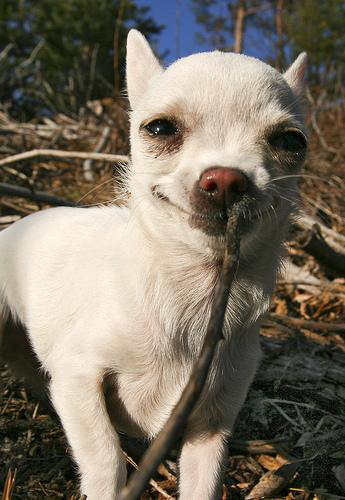

In [105]:
image

In [106]:
image = trasformer(image).float()

In [107]:
from torch.autograd import Variable
image_var = Variable(image, requires_grad=True)

In [108]:
image_var.size()

torch.Size([3, 120, 120])

In [109]:
image_for_pred = image_var.view(1,3,120,120)

In [110]:
image_for_pred.size()

torch.Size([1, 3, 120, 120])

In [111]:
image_for_pred_to_device = image_for_pred.to(device)

In [114]:
output = model(image_for_pred_to_device)

In [115]:
output

tensor([[  9.0858,  -0.1673,   2.7420,   0.4611,  -0.3592,   5.1920,   0.6805,
           4.4828,  -1.3288,   0.2388,  -1.3502,   4.6749,   0.5622,   2.4521,
          -2.1844,   3.5650,   0.3828,   1.3130,  -0.0858,   5.4325,   4.3076,
           4.3908,   0.9933,   0.7125,  -2.0006,   0.5790,   0.3314,   4.4774,
           0.9997,   5.2948,  -3.2610,   3.6215,  -2.4579,  -5.4377,  -1.2440,
          -1.5224,   3.0556,  -0.0235,   3.2678,  -0.6039,   2.8892,   2.8009,
          -0.6069,   1.9816,   2.4655,  -3.7339,  -4.0645,   0.6573,  -0.9314,
          -0.3232,   1.3614,   1.5316,  -2.0455,   1.1306,  -2.5169,  -2.6748,
           1.1845,   3.0553,  -0.6922,   5.8780,  -5.7985,  -0.2179,  -4.3552,
          -6.1332,   3.8552,   0.8584,  -1.1299,   2.0162,   1.3308,   0.7544,
          -3.6927,  -0.2627,  -0.9634,  -3.2176,   1.4416,  -1.5462,   0.3985,
           1.0171,  -0.6697,   0.8385,  -1.7740,  -3.4970,  -7.7967, -10.1252,
           3.5709,   0.6592,   1.2233,  -1.9594,  -5

In [116]:
indices = torch.argmax(output, 1)

In [117]:
indices

tensor([0])

In [118]:
breed = test_loader.dataset.classes[indices]
breed

'n02085620-Chihuahua'

In [119]:
# Now with a function
def predict_image_path(path, transformer, model, image_width=120, image_length=120):
    """
    Receives an image path and returns the class (breed)
    """
    
    image = Image.open(path)
    trans_image = transformer(image).float()
    image_var = Variable(trans_image, requires_grad=True)
    image_for_pred = image_var.view(1,3,image_width,image_length)
    image_for_pred_to_device = image_for_pred.to(device)
    output = model(image_for_pred_to_device)
    
    indices = torch.argmax(output, 1)
    breed = test_loader.dataset.classes[indices]
    
    return breed

In [121]:
predict_image_path('/home/ishay/Documents/MDLI/dogs/data/Images/n02085620-Chihuahua/n02085620_1073.jpg',
                  trasformer,
                  model)

'n02085620-Chihuahua'

In [122]:
model.conv1.weight

Parameter containing:
tensor([[[[-1.3242e-01, -1.0070e-01, -1.6337e-01, -6.7316e-02, -2.0656e-01],
          [-4.8324e-03, -1.9589e-01, -2.0937e-01, -1.8950e-01, -5.1539e-02],
          [-1.1877e-01, -5.4513e-02, -2.0604e-01, -1.7386e-01, -1.2314e-01],
          [-6.9576e-02, -1.5895e-01, -3.0640e-05, -9.0213e-02, -3.3536e-03],
          [ 7.8453e-02, -2.0225e-03,  3.0155e-03,  1.0056e-01, -4.6338e-02]],

         [[-2.8036e-02, -1.3240e-01,  2.9653e-03,  9.1749e-03, -1.9040e-01],
          [ 3.0708e-02, -3.2423e-02, -4.0132e-02, -4.0897e-02,  1.5918e-02],
          [-7.0840e-02, -1.7131e-01, -1.1426e-01, -1.6006e-01, -5.2806e-02],
          [-5.1734e-02, -1.1321e-01, -6.4736e-02,  6.4167e-02, -3.4513e-02],
          [ 1.2384e-02, -2.7968e-02,  2.8298e-03,  1.0171e-01,  8.4914e-02]],

         [[ 7.1725e-02,  4.2472e-02,  4.8067e-02,  6.0147e-02, -4.8585e-03],
          [-8.0407e-02, -6.1622e-02,  1.0685e-01,  1.5490e-02, -8.2019e-02],
          [ 5.2487e-02,  1.1421e-01, -9.6110e-02, 